In [9]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
# from public_tests import *
%matplotlib inline

result resolution: (607, 736)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D) 

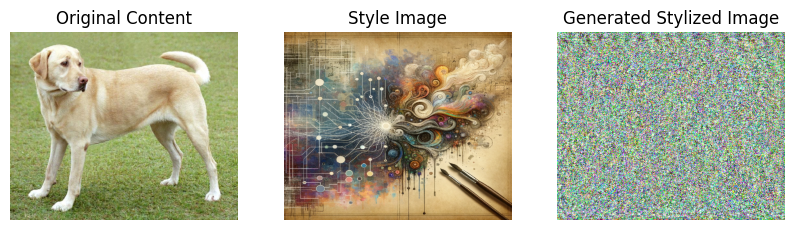

Epoch 1/10


1/1 [==============================] - 20s 20s/step - loss: 845.1642 - block1_conv1_loss: 0.0791 - block1_conv2_loss: 1.6397 - block1_pool_loss: 1.9698 - block2_conv1_loss: 3.2145 - block2_conv2_loss: 8.0199 - block2_pool_loss: 13.3282 - block3_conv1_loss: 9.0312 - block3_conv2_loss: 12.8829 - block3_conv3_loss: 36.2724 - block3_conv4_loss: 139.5700 - block3_pool_loss: 191.7133 - block4_conv1_loss: 174.3255 - block4_conv2_loss: 158.7565 - block4_conv3_loss: 60.8098 - block4_conv4_loss: 8.6407 - block4_pool_loss: 18.6781 - block5_conv1_loss: 4.7118 - block5_conv2_loss: 1.0002 - block5_conv3_loss: 0.2516 - block5_conv4_loss: 0.0801 - block5_pool_loss: 0.1107 - input_17_loss: 0.0781
Epoch 2/10
1/1 [==============================] - 16s 16s/step - loss: 700.5330 - block1_conv1_loss: 0.0786 - block1_conv2_loss: 1.6507 - block1_pool_loss: 1.9801 - block2_conv1_loss: 3.6105 - block2_conv2_loss: 8.0692 - block2_pool_loss: 12.1416 - block3_conv1_loss: 8.8839 - block3_conv2_loss: 14.9603 - block

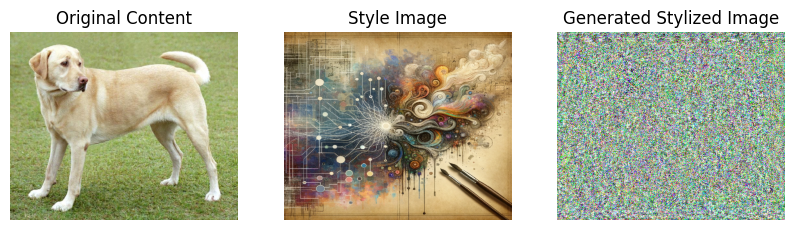

In [10]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt

# Generated image size
RESIZE_HEIGHT = 607

NUM_ITER = 30

# Weights of the different loss components
CONTENT_WEIGHT = 8e-4 # 8e-4
STYLE_WEIGHT = 8e-1 # 8e-4


#############################################################
##################### Model Architecture ####################
#############################################################

# Athough Vgg19 is basically used for Classification purpose,
# but here our objective is not to classify rather our objective
#  is to transform a image, so we do not need all the layers of
#  vgg19, we have specially excluded those layers which are used
#  for classification.

## I am using a pre-trained VGG19 model. so there is no need to
## train the model here. We only have to fine tune this.

# Content layer where will pull our feature maps
CONTENT_LAYER_NAME = "block5_conv2" # "block2_conv2"

# List of layers to use for the style loss.
STYLE_LAYER_NAMES = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

def get_result_image_size(image_path, result_height):
    """
    Calculate the width of the result image while maintaining the specified height.

    Parameters:
        image_path (str): Path to the input image.
        result_height (int): Desired height for the result image.

    Returns:
        tuple: A tuple containing the calculated result height and width.

    This function loads an image from the provided path using Keras's image module,
    extracts its original width and height, and then calculates the corresponding width
    to maintain the desired height for the result image. The result is returned as a tuple
    of (result_height, result_width).
    """
    image_width, image_height = keras.preprocessing.image.load_img(image_path).size
    result_width = int(image_width * result_height / image_height)
    return result_height, result_width

def preprocess_image(image_path, target_height, target_width):
    """
    Preprocess an image for compatibility with the VGG19 model.

    Parameters:
        image_path (str): Path to the input image.
        target_height (int): Desired height for the preprocessed image.
        target_width (int): Desired width for the preprocessed image.

    Returns:
        tf.Tensor: Preprocessed image as a TensorFlow tensor.

    This function loads an image from the provided path using Keras's image module,
    resizes it to the specified target height and width, converts it to a NumPy array,
    expands its dimensions, and then applies the VGG19 preprocessing.
    The resulting preprocessed image is returned as a TensorFlow tensor.
    """
    img = keras.preprocessing.image.load_img(image_path, target_size = (target_height, target_width))
    arr = keras.preprocessing.image.img_to_array(img)
    arr = np.expand_dims(arr, axis = 0)
    arr = vgg19.preprocess_input(arr)
    return tf.convert_to_tensor(arr)

def get_model():
    """
    Build and return a VGG19 model with pre-trained ImageNet weights.

    Returns:
        keras.Model: VGG19 model with activations for each layer as outputs.

    This function constructs a VGG19 model pre-trained on ImageNet weights using Keras.
    It then creates a dictionary mapping layer names to their corresponding symbolic outputs.
    Finally, it sets up a new model that takes the original model's inputs and outputs the
    activation values for every layer, returning this modified model.
    """
    model = vgg19.VGG19(weights='imagenet', include_top=False)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    return keras.Model(inputs=model.inputs, outputs=outputs_dict)


def get_optimizer():
    """
    Return an Adam optimizer with an exponentially decaying learning rate.

    Returns:
        keras.optimizers.Adam: Adam optimizer with an exponentially decaying learning rate.

    This function configures and returns an Adam optimizer using Keras. The learning rate
    is set to decay exponentially, with an initial learning rate of 8.0, decay steps of 445,
    and a decay rate of 0.98. You can optionally adjust the commented values for different
    learning rate configurations.
    """
    return keras.optimizers.Adam(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=8.0, decay_steps=445, decay_rate=0.98
            # Alternatively, use the commented values for a different configuration
            # initial_learning_rate=2.0, decay_steps=376, decay_rate=0.98
        )
    )


def compute_loss(feature_extractor, combination_image, content_features, style_features):
    """
    Compute the total loss for style transfer.

    Parameters:
        feature_extractor (keras.Model): Feature extractor model.
        combination_image (tf.Tensor): Combined image for style transfer.
        content_features (dict): Content features from the content image.
        style_features (dict): Style features from the style image.

    Returns:
        tf.Tensor: Total loss for style transfer.

    This function computes the total loss for style transfer, combining content and style losses.
    It uses a feature extractor to obtain features from the combination image and calculates
    content loss and style loss using the provided content and style features.
    The total loss is a weighted sum of the content and style losses.
    """
    combination_features = feature_extractor(combination_image)
    loss_content = compute_content_loss(content_features, combination_features)
    loss_style = compute_style_loss(style_features, combination_features, combination_image.shape[1] * combination_image.shape[2])

    return CONTENT_WEIGHT * loss_content + STYLE_WEIGHT * loss_style


def compute_content_loss(content_features, combination_features):
    """
    Compute content loss between original and generated images.

    Parameters:
        content_features (dict): Content features from the original image.
        combination_features (dict): Content features from the generated image.

    Returns:
        tf.Tensor: Content loss.

    This function computes the content loss by comparing the features of a specific layer
    ('CONTENT_LAYER_NAME') in the original and generated images.
    """
    original_image = content_features[CONTENT_LAYER_NAME]
    generated_image = combination_features[CONTENT_LAYER_NAME]

    return tf.reduce_sum(tf.square(generated_image - original_image)) / 2

def compute_style_loss(style_features, combination_features, combination_size):
    """
    Compute style loss between style and generated images.

    Parameters:
        style_features (dict): Style features from the style image.
        combination_features (dict): Style features from the generated image.
        combination_size (int): Size of the generated image.

    Returns:
        tf.Tensor: Style loss.

    This function computes the style loss by comparing features from multiple layers
    ('STYLE_LAYER_NAMES') in the style and generated images. The loss is averaged over
    the selected layers to ensure consistent contributions.
    """
    loss_style = 0

    for layer_name in STYLE_LAYER_NAMES:
        style_feature = style_features[layer_name][0]
        combination_feature = combination_features[layer_name][0]
        loss_style += style_loss(style_feature, combination_feature, combination_size) / len(STYLE_LAYER_NAMES)

    return loss_style


# The "style loss" is designed to maintain the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image
def style_loss(style_features, combination_features, combination_size):
    S = gram_matrix(style_features)
    C = gram_matrix(combination_features)
    channels = style_features.shape[2]
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (combination_size ** 2))

def gram_matrix(x):
   x = tf.transpose(x, (2, 0, 1))
   features = tf.reshape(x, (tf.shape(x)[0], -1))
   gram = tf.matmul(features, tf.transpose(features))
   return gram

def save_result(generated_image, result_height, result_width, name):
    img = deprocess_image(generated_image, result_height, result_width)
    keras.preprocessing.image.save_img(name, img)

# Util function to convert a tensor into a valid image
def deprocess_image(tensor, result_height, result_width):
    tensor = tensor.numpy()
    tensor = tensor.reshape((result_height, result_width, 3))

    # Remove zero-center by mean pixel
    tensor[:, :, 0] += 103.939
    tensor[:, :, 1] += 116.779
    tensor[:, :, 2] += 123.680

    # 'BGR'->'RGB'
    tensor = tensor[:, :, ::-1]
    return np.clip(tensor, 0, 255).astype("uint8")


def evaluate_style_transfer(generated_image, content_image_path, style_image_path, result_height, result_width):
    """
    Evaluate the style transfer result based on specified criteria.

    Parameters:
        generated_image (tf.Tensor): Generated stylized image.
        content_image_path (str): Path to the original content image.
        style_image_path (str): Path to the style image.
        result_height (int): Height of the result image.
        result_width (int): Width of the result image.

    Returns:
        None

    This function displays the original content image, the style image, and the generated stylized image.
    """
    # Load original content and style images
    content_img = keras.preprocessing.image.load_img(content_image_path, target_size=(result_height, result_width))
    style_img = keras.preprocessing.image.load_img(style_image_path, target_size=(result_height, result_width))

    # Display images using matplotlib
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(content_img)
    plt.title('Original Content')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(style_img)
    plt.title('Style Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(generated_image[0])  # Assuming the batch dimension is 1
    plt.title('Generated Stylized Image')
    plt.axis('off')

    plt.show()

def adapt_style_representation(style_rep_model, content_tensor, new_style_tensor, num_epochs=10):
    """
    Adapt the learned style features to new works.

    Parameters:
        style_rep_model (keras.Model): Style representation model.
        content_tensor (tf.Tensor): Content image as a TensorFlow tensor.
        new_style_tensor (tf.Tensor): New style image as a TensorFlow tensor.
        num_epochs (int): Number of training epochs for adaptation.

    Returns:
        None

    This function adapts the learned style features to new works by updating the
    style representation model using content and new style images.
    """
    # Extract style features for the content image
    content_features = style_rep_model(content_tensor)

    # Compile the model for training
    style_rep_model.compile(optimizer='adam', loss='mse')

    # Train the style representation model with the new style features
    style_rep_model.fit(new_style_tensor, content_features, epochs=num_epochs, verbose=1)



def style_transfer(content_tensor, style_tensor, num_iterations=30):
    """
    Perform style transfer between content and style images.

    Parameters:
        content_tensor (tf.Tensor): Content image as a TensorFlow tensor.
        style_tensor (tf.Tensor): Style image as a TensorFlow tensor.
        num_iterations (int): Number of optimization iterations.

    Returns:
        tf.Tensor: Stylized image as a TensorFlow tensor.

    This function performs style transfer between a content image and a style image
    using an optimization approach. It initializes a generated image and optimizes it
    to minimize the content and style losses.
    """
    generated_image = tf.Variable(tf.random.uniform(content_tensor.shape, dtype=tf.dtypes.float32))

    # Build the style transfer model
    model = get_model()
    optimizer = get_optimizer()

    # Precompute features for content and style images
    content_features = model(content_tensor)
    style_features = model(style_tensor)

    # Optimize the generated image
    for iter in range(num_iterations):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, generated_image, content_features, style_features)

        grads = tape.gradient(loss, generated_image)
        optimizer.apply_gradients([(grads, generated_image)])

    return generated_image




if __name__ == "__main__":
    # Prepare content, stlye images
    # path = os.path.abspath(os.getcwd())
    # content_image_path = keras.utils.get_file(path + '\dataset\paris.jpg', 'https://i.imgur.com/F28w3Ac.jpg')
    # style_image_path = keras.utils.get_file(path + '\dataset\starry_night.jpg', 'https://i.imgur.com/9ooB60I.jpg')
    content_image_path = '/content/context.jpg'
    style_image_path = '/content/style.png'
    result_height, result_width = get_result_image_size(content_image_path, RESIZE_HEIGHT)
    print("result resolution: (%d, %d)" % (result_height, result_width))

    # Preprocessing
    content_tensor = preprocess_image(content_image_path, result_height, result_width)
    style_tensor = preprocess_image(style_image_path, result_height, result_width)
    content_tensor/=255.0
    style_tensor/=255.0
    generated_image = tf.Variable(tf.random.uniform(style_tensor.shape, dtype=tf.dtypes.float32))
    # generated_image = tf.Variable(preprocess_image(content_image_path, result_height, result_width))

    # Build model
    model = get_model()
    optimizer = get_optimizer()
    print(model.summary())

    content_features = model(content_tensor)
    style_features = model(style_tensor)

    # Optimize result image
    for iter in range(NUM_ITER):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, generated_image, content_features, style_features)

        grads = tape.gradient(loss, generated_image)

        print("iter: %4d, loss: %8.f" % (iter, loss))
        optimizer.apply_gradients([(grads, generated_image)])

    # Generate stylized image
    generated_imagee = style_transfer(content_tensor, style_tensor, num_iterations=NUM_ITER)

    # Evaluate Style Transfer
    evaluate_style_transfer(generated_imagee, content_image_path, style_image_path, result_height, result_width)

    # Adapt Style Representation
    new_style_image_path = '/content/style.png'
    new_style_tensor = preprocess_image(new_style_image_path, result_height, result_width) / 255.0

    # Assuming style_rep_model is defined
    style_rep_model = get_model()

    # Adapt style representation to new style
    adapt_style_representation(style_rep_model, content_tensor, new_style_tensor, num_epochs=10)

    # Generate stylized image with the adapted style
    adapted_generated_image = style_transfer(content_tensor, new_style_tensor, num_iterations=NUM_ITER)

    # Convert TensorFlow variable to NumPy array
    adapted_image_array = adapted_generated_image.numpy()

    # Evaluate Adapted Style Transfer
    evaluate_style_transfer(adapted_image_array, content_image_path, new_style_image_path, result_height, result_width)

# Convert TensorFlow variable to NumPy array
image_array = generated_image.numpy()

# Display the image using matplotlib
# plt.imshow(image_array[0])  # Assuming the batch dimension is 1
# plt.axis('off')  # Optional: Turn off axis labels
# plt.show()

Due to resource constraints, set NUM_ITER to 30 (instead of 3000) in the Neural Style Transfer implementation for quicker results. This parameter controls the optimization iterations during style transfer. Adjusting it to a lower value ensures a faster process, albeit with a potential trade-off in the stylization quality.

---

